<a href="https://colab.research.google.com/github/Kakarum/Finding-Near-Duplicate-Reviews-in-Amazon-Book-Reviews-using-Jaccard-and-MinHash-LSH-/blob/main/Similar_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#################### DEPENDENCIES AND PARAMETERS ##########################################

import sys
from pathlib import Path
from pyspark.sql import SparkSession, functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, MinHashLSH
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import numpy as np


# Install Kaggle and PySpark
!pip install kaggle
!pip install pyspark==3.5.1

# Configuration
KAGGLE_USERNAME = "xxxxxxxxxxx"    # FILL
KAGGLE_KEY = "xxxxxxxxxxxxxxx"         # FILL
AMAZON_PATH = "mohamedbakhet/amazon-books-reviews"
AMAZON_CSV  = "Books_rating.csv"
REVIEW_COLUMN = "review/text"


# Sampling and Similarity parameters
RAND_SEED = 10
SUBSAMPLE = True
SUB_FRACTION = 0.20 # 0.20 means 20% of the data will be sampled
SUB_MAX_ROWS = 20_000
SIMILARITY_THRESHOLD = 0.8
PAIRS = 100

# The dataset's ID column refers to the book (not the single review), so we want a synthetic per-row ID.
ID_COL = False # In case you have a ID column put it here

############################ SETUP (Spark + Kaggle + dataset) ###############################################

import os
# Makes sure Spark uses the current Python interpreter (driver and executors)
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

# Check credential
if not KAGGLE_USERNAME or not KAGGLE_KEY:
    raise RuntimeError("You need to set KAGGLE_USERNAME and KAGGLE_KEY at the top.")

# Environment variables for Kaggle API
os.environ["KAGGLE_USERNAME"] = KAGGLE_USERNAME
os.environ["KAGGLE_KEY"] = KAGGLE_KEY

# Authenticate and download
from kaggle.api.kaggle_api_extended import KaggleApi
API = KaggleApi()      # API initializer
API.authenticate()     # API authenticator

download_dir = "/content/data"
os.makedirs(download_dir, exist_ok=True)

# Recursive function to find the target CSV before download
candidates = sorted(Path(download_dir).rglob(AMAZON_CSV))  # recursive search for the CSV
if not candidates:
    print(f"Downloading '{AMAZON_PATH}' to {download_dir} ...")
    API.dataset_download_files(AMAZON_PATH, path=download_dir, unzip=True, force=False) # Force= False won't download the archive again if already present
    candidates = sorted(Path(download_dir).rglob(AMAZON_CSV))
    if not candidates:
      raise FileNotFoundError(f"Could not find {AMAZON_CSV} under {download_dir} after download.")
else:
  print("CSV already present, skipping download.")

DATASET_CSV = str(candidates[0])  # pick the first (sorted by path)
print("Found CSV:", DATASET_CSV)


Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
Found CSV: /content/data/Books_rating.csv


In [2]:
################################## SPARK PIPELINE #############################################

spark = (
    SparkSession.builder
    .appName("Jaccard_similarity_amazon_reviews")
    .getOrCreate()
)

# Load CSV into Spark DataFrame
spark_df = (
    spark.read
    .option("header", True)
    .option("multiLine", True)  # allow newlines inside quoted fields without breaking records
    .option("escape", '\\')      # allow literal quotes inside a quoted field without closing it
    .option("quote", '"')       # commas/newlines inside quotes are treated as part of the field
    .csv(DATASET_CSV)
)

# Fail if the expected text column is missing
if REVIEW_COLUMN not in spark_df.columns:
    raise ValueError(f"Column {REVIEW_COLUMN!r} not found in CSV.")

# Select doc_id + text
# If a unique per-row review ID exists and you set ID_COL to that column name, use it; otherwise create a synthetic one.
if ID_COL and ID_COL in spark_df.columns:
    spark_df = spark_df.select(F.col(ID_COL).alias("doc_id"), F.col(REVIEW_COLUMN).alias("text"))
else:
    spark_df = spark_df.select(F.monotonically_increasing_id().alias("doc_id"), F.col(REVIEW_COLUMN).alias("text"))


ROWS — raw: 3000000 | non-empty: 2999992 | sampled: 600322 | capped: 20000
Rows after subsample: 20000
Character-length stats:
+-----+---------+---------+------------------+---------+---------+---------+
|n    |avg_chars|p50_chars|p90_chars         |p99_chars|min_chars|max_chars|
+-----+---------+---------+------------------+---------+---------+---------+
|20000|841.77865|530.5    |1879.1000000000022|4689.0   |1        |29336    |
+-----+---------+---------+------------------+---------+---------+---------+



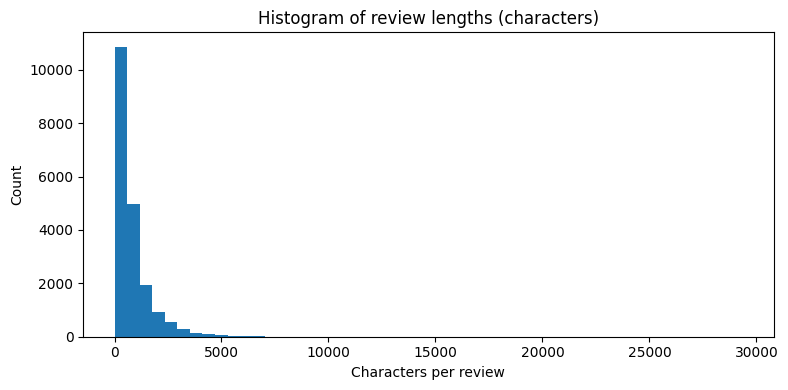

In [3]:
######################################## DESCRIPTIVE STATS ##############################################

# Count per stage
n_raw = spark_df.count()

nonempty_df = spark_df.where(
    F.col("text").isNotNull() & (F.length(F.trim(F.col("text"))) > 0)
)
n_nonempty = nonempty_df.count()

sampled_df = (nonempty_df.sample(False, float(SUB_FRACTION), seed=int(RAND_SEED)) if SUBSAMPLE else nonempty_df)
n_sampled = sampled_df.count()

capped_df = (sampled_df.limit(int(SUB_MAX_ROWS)) if SUB_MAX_ROWS is not None else sampled_df)
n_capped = capped_df.count()

print("ROWS — raw:", n_raw, "| non-empty:", n_nonempty, "| sampled:", n_sampled, "| capped:", n_capped)

spark_df = capped_df # Replace working DataFrame with the capped one
print("Rows after cap:", spark_df.count())

# Distribution of review lengths
char_stats = (spark_df
              .select(F.length(F.col("text")).alias("char_len"))
              .agg(
                  F.count("*").alias("n"),
                  F.avg("char_len").alias("avg_chars"),
                  F.expr("percentile(char_len, 0.5)").alias("p50_chars"),
                  F.expr("percentile(char_len, 0.9)").alias("p90_chars"),
                  F.expr("percentile(char_len, 0.99)").alias("p99_chars"),
                  F.min("char_len").alias("min_chars"),
                  F.max("char_len").alias("max_chars"),
              )
              )
print("Character-length stats:")
char_stats.show(truncate=False)


# Histogram of review lengths (characters)
# We use a bounded sample for plotting
lengths_df = spark_df.select(F.length(F.col("text")).alias("char_len")) # df with character lengths
lengths_sample = lengths_df.sample(False, 0.2, seed=RAND_SEED) if n_capped > 50000 else lengths_df
lengths = [int(r.char_len) for r in lengths_sample.limit(100000).collect()]  # cap at 100k points

plt.figure(figsize=(8, 4))
plt.hist(lengths, bins=50)
plt.title("Histogram of review lengths (characters)")
plt.xlabel("Characters per review")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


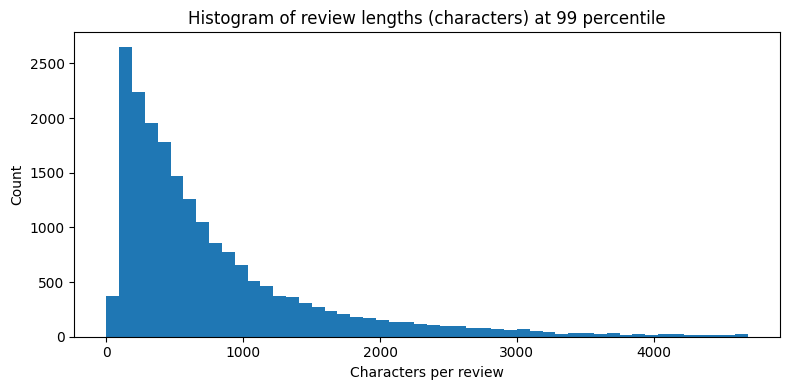

In [4]:
# Histogram at 99 percentile
p99 = np.percentile(lengths, 99)  # knowing it's skewed I cut at 99 percentile
plt.figure(figsize=(8, 4))
plt.hist(lengths, bins=50, range=(0, p99))
plt.title("Histogram of review lengths (characters) at 99 percentile")
plt.xlabel("Characters per review")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [5]:
############################ NLP: Tokenization → Stopwords → Binary Bag of Words ##########################################

# Split on non-word characters (spaces, punctuation)
tokenizer = RegexTokenizer(inputCol="text", outputCol="tokens", pattern=r"\W+", toLowercase=True)

# Remove stopwords, takes tokens and gives a filtered word list
remover = StopWordsRemover(inputCol="tokens", outputCol="words")

# Binary Bag-of-Words
cv = CountVectorizer(
    inputCol="words",
    outputCol="features",
    binary=True,
    vocabSize=1_000_000,
    minDF=4
)

# ML pipeline: tokenizer → stopwords remover → vectorizer
pipe = Pipeline(stages=[tokenizer, remover, cv])
prep = pipe.fit(spark_df)            # fit where needed (CountVectorizer builds the vocabulary)
featurized = prep.transform(spark_df)  # add columns tokens, words, features

In [6]:
################################## Clean empty docs and cache  #################################################

# udf count non-zero elements in the sparse vector
nonzeros = F.udf(lambda v: int(v.numNonzeros()) if v is not None else 0, IntegerType())

# Filter out rows with no words or zero vectors
featurized = featurized.where(F.size(F.col("words")) > 0)
featurized = featurized.where(nonzeros(F.col("features")) > 0).cache()

# Error if empty
kept = featurized.count()
if kept == 0:
    raise RuntimeError("NO rows remaining after filtering.")
print("Rows after features (non-empty rows):", kept)

# Quick diagnostics, total tokens and longest doc
words_count = featurized.select(F.size(F.col("words")).alias("n")).agg(F.sum("n")).first()[0]
longest = featurized.select("doc_id", F.size(F.col("words")).alias("n")).orderBy(F.desc("n")).limit(1).collect()
print(f"Total tokens after filtering: {words_count}")
if longest:
    print(f"Doc with most tokens: id={longest[0]['doc_id']} tokens={longest[0]['n']}")

Rows after features (non-empty rows): 19999
Total tokens after filtering: 1532569
Doc with most tokens: id=33182 tokens=1591


In [7]:
########################################## MinHash LSH ##############################################

lsh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=6) # numHashTables between 4-12
lsh_model = lsh.fit(featurized)  # builds LSH structures over the feature vectors

# approxSimilarityJoin wants a distance threshold so we need to convert similarity
dist_threshold = 1.0 - float(SIMILARITY_THRESHOLD)
pairs_base = (
    lsh_model
    .approxSimilarityJoin(featurized, featurized, dist_threshold, distCol="jaccard_dist")
    .where(F.col("datasetA.doc_id") < F.col("datasetB.doc_id"))  # avoid A==B and symmetric duplicates (A,B)/(B,A)
    .select(
        F.col("datasetA.doc_id").alias("doc_id_A"),
        F.col("datasetB.doc_id").alias("doc_id_B"),
        (1.0 - F.col("jaccard_dist")).alias("jaccard_sim"),
        F.col("datasetA.text").alias("text_A"),
        F.col("datasetB.text").alias("text_B"),
    )
    .cache()
)

sim_stats = (pairs_base
      .agg(
          F.count("*").alias("n"),
          F.avg("jaccard_sim").alias("avg_sim"),
          F.min("jaccard_sim").alias("min_sim"),
          F.max("jaccard_sim").alias("max_sim"),
          F.expr("percentile(jaccard_sim, 0.5)").alias("p50"),
          F.expr("percentile(jaccard_sim, 0.9)").alias("p90"),
          F.expr("percentile(jaccard_sim, 0.99)").alias("p99"),
      ))
print("\nSimilarity stats (Jaccard):")
sim_stats.show(truncate=False)

top = (pairs_base
       .orderBy(F.desc("jaccard_sim"))
       .limit(int(PAIRS))
       .collect())

print(f"\n------ Similar review pairs (Spark, Jaccard ≥ {SIMILARITY_THRESHOLD}) ------")
if not top:
    print("(no pairs found at this threshold)")
else:
    def snip(s, n=100):
        if not s:
            return ""
        s = s.replace("\n", " ").strip()
        return s[:n] + ("…" if len(s) > n else "")

    for r in top:
        print(f"[{r.doc_id_A} vs {r.doc_id_B}] sim={r.jaccard_sim:.3f}")
        print(f" A: {snip(r.text_A)}")
        print(f" B: {snip(r.text_B)}")
        print("-" * 80)



Similarity stats (Jaccard):
+---+-----------------+------------------+-------+---+---+---+
|n  |avg_sim          |min_sim           |max_sim|p50|p90|p99|
+---+-----------------+------------------+-------+---+---+---+
|402|0.993359146002045|0.8247422680412371|1.0    |1.0|1.0|1.0|
+---+-----------------+------------------+-------+---+---+---+


------ Similar review pairs (Spark, Jaccard ≥ 0.8) ------
[16991 vs 61603] sim=1.000
 A: Could we end up like this in our future? What would the world be like without books?? This story giv…
 B: Could we end up like this in our future? What would the world be like without books?? This story giv…
--------------------------------------------------------------------------------
[35174 vs 77629] sim=1.000
 A: So many people have read this classic book that if you are one of the few who haven't then give it a…
 B: So many people have read this classic book that if you are one of the few who haven't then give it a…
-------------------------------------